In [1]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import category_encoders as ce

# Visualization
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
import seaborn as sns
%matplotlib inline

# Preprocessing & Feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectPercentile

# Hyperparameter Optimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Modeling
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.base import ClassifierMixin

# PyTorch
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import Parameter
from torch import Tensor
from torch.utils.data import DataLoader

# Evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss

# Utility
import os
import time
import datetime
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
import pickle
from tqdm import tqdm
import platform
from itertools import combinations
from scipy.stats.mstats import gmean

from bayes_opt import BayesianOptimization
from num2words import num2words
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence

In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
international_trade = pd.read_csv('../data/international_trade.csv')
train.drop(columns = 'ID', inplace = True)
test.drop(columns = 'ID', inplace = True)

In [3]:
train = train.rename(columns={'supply(kg)':'supply','price(원/kg)':'price'})
train.columns

Index(['timestamp', 'item', 'corporation', 'location', 'supply', 'price'], dtype='object')

In [4]:
# 시계열 데이터 처리
train.timestamp = pd.to_datetime(train.timestamp)
test.timestamp = pd.to_datetime(test.timestamp)

########### test 데이터 supply 컬럼 추가
# test['supply'] = np.zeros((len(test),1))
# def find_lastyear_supply(row):
#     # date1 : 1년 전 같은 datetime
#     date1 = pd.to_datetime(f'{row["timestamp"].year-1}-{row["timestamp"].month}-{row["timestamp"].day}').date()
#     # date2 : 2년 전 같은 datetime
#     date2 = pd.to_datetime(f'{row["timestamp"].year-2}-{row["timestamp"].month}-{row["timestamp"].day}').date()
# #     print(date)
#     # 1,2년 전 같은 날짜 & 유통업체 & 지역 & 품목의 supply 평균값으로 test에 supply컬럼 추가
#     row['supply'] = train[((train['timestamp'].dt.date==date1)|(train['timestamp'].dt.date==date2))&
#                             (train['corporation']==row['corporation'])&
#                             (train['location']==row['location']) &
#                             (train['item']==row['item'])]['supply'].sum()
# #     print(row['supply'])
#     return row
# test = test.apply(find_lastyear_supply,axis=1)
########### test 데이터 supply 컬럼 추가 -END-

# year
train['year'] = train.timestamp.dt.year
test['year'] = test.timestamp.dt.year

# month
train['month'] = train.timestamp.dt.month
test['month'] = test.timestamp.dt.month

# day
train['day'] = train.timestamp.dt.day
test['day'] = test.timestamp.dt.day

# week
train['week'] = train.timestamp.dt.dayofweek
test['week'] = test.timestamp.dt.dayofweek

# 주말여부
train['weekend'] = train.week.apply(lambda x : 1 if x in [1,2] else 0)
test['weekend'] = test.week.apply(lambda x : 1 if x in [1,2] else 0)

# date (월-일)
train['date'] = train.timestamp.apply(lambda x : int(str(x)[5:7] + str(x)[8:10]))
test['date'] = test.timestamp.apply(lambda x : int(str(x)[5:7] + str(x)[8:10]))

# year_month
train['year_month'] = train.timestamp.apply(lambda x : str(x)[0:7])
test['year_month'] = test.timestamp.apply(lambda x : str(x)[0:7])

In [5]:
# test에 supply 잘 들어갔는지 확인
# print(test[(test['timestamp']=='2023-03-27')&(test['item']=='RD')&(test['corporation']=='F')&(test['location']=='J')]['supply'])
# print(train[(train['timestamp']=='2021-03-27')&(train['item']=='RD')&(train['corporation']=='F')&(train['location']=='J')]['supply'])
# print(train[(train['timestamp']=='2022-03-27')&(train['item']=='RD')&(train['corporation']=='F')&(train['location']=='J')]['supply'])

In [6]:
# 감귤과 나머지로 데이터프레임 구분
tg_train_index = train[train['item']=='TG'].index
train_TG = train.iloc[tg_train_index,:]
train_rest = train.drop(index=tg_train_index,axis=0)

tg_test_index = test[test['item']=='TG'].index
test_TG = test.iloc[tg_test_index,:]
test_rest = test.drop(index=tg_test_index,axis=0)

## 후에 사용할 test 데이터셋의 인덱스를 미리 저장
org_test_TG_index = test_TG.index
org_test_rest_index = test_rest.index

In [7]:
# Encoding 
encoders_TG = {}
for col in ['item','corporation']:
    encoder = ce.TargetEncoder()
    train_TG[col] = encoder.fit_transform(train_TG[col],train_TG['price'])
    test_TG[col] = encoder.transform(test_TG[col])
    encoders_TG[col] = encoder
encoder = LabelEncoder()
train_TG['location'] = encoder.fit_transform(train_TG['location'])
test_TG['location'] = encoder.transform(test_TG['location'])
encoders_TG['location'] = encoder

encoders_rest = {}
for col in ['item','corporation']:
    encoder = ce.TargetEncoder()
    train_rest[col] = encoder.fit_transform(train_rest[col],train_rest['price'])
    test_rest[col] = encoder.transform(test_rest[col])
    encoders_rest[col] = encoder
encoder = LabelEncoder()
train_rest['location'] = encoder.fit_transform(train_rest['location'])
test_rest['location'] = encoder.transform(test_rest['location'])
encoders_rest['location'] = encoder

In [62]:
# drop unnecessary cols, define features and target
train_TG_ = train_TG.drop(columns = ['timestamp', 'year_month'])
train_rest_ = train_rest.drop(columns = ['timestamp', 'year_month'])
test_TG_ = test_TG.drop(columns = ['timestamp', 'year_month'])
test_rest_ = test_rest.drop(columns = ['timestamp', 'year_month'])

feature_TG = train_TG_.drop(columns=['supply','price']) # 피처에 supply 미포함
feature_te_TG = test_TG_ #.drop(columns=['supply'])  피처에 supply 미포함
feature_rest = train_rest_.drop(columns=['supply','price']) 
feature_te_rest = test_rest_ #.drop(columns=['supply']) 
# feature = train_.drop(columns=['price']) # 피처에 supply 포함하는 버전
# feature_te = test_
target_TG = train_TG_.price
target_rest = train_rest_.price

여기서부터 lgbm전까지는 feature_TG, target_TG로 LSTM모델을 사용하여 학습 및 예측
<br/>
참고 : https://github.com/jungsungmoon/nongsan#eda

In [45]:
print(torch.cuda.is_available())
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(torch.cuda.get_device_name())
print(torch.cuda.device_count())

True
NVIDIA GeForce RTX 3050 Ti Laptop GPU
1


In [74]:
# define LSTM Model
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim,num_layers):
        super(LSTM,self).__init__()
        self.input_dim = input_dim,
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, 
                           batch_first=True).to(device)
        self.pool = nn.AdaptiveAvgPool2d((1,1)).to(device)
        self.fc0 = nn.Linear(num_layers,hidden_dim)
        self.fc1 = nn.Linear(hidden_dim, 32).to(device)
        self.fc2 = nn.Linear(32,output_dim).to(device)
        self.dropout = nn.Dropout(0.2).to(device)
        
    def forward(self, x):
        # lstm 셀 및 가중치 초기화
        h_0 = Variable(torch.zeros(self.num_layers,x.size(0),self.hidden_dim)).to(device)
        c_0 = Variable(torch.zeros(self.num_layers,x.size(0),self.hidden_dim)).to(device)
        
        out,(hn,cn) = self.lstm(x, (h_0,c_0))
        out = self.pool(hn)
        print(out.size())
#         hn_ = hn.view(-1,self.hidden_dim)
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out
    
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

In [64]:
feature_TG.columns

Index(['item', 'corporation', 'location', 'year', 'month', 'day', 'week',
       'weekend', 'date'],
      dtype='object')

In [75]:
# Model instance , criterion, optimizer
input_dim = feature_TG.shape[1]
hidden_dim = 30
output_dim = 1
num_layers = 3

model = LSTM(input_dim, hidden_dim, output_dim, num_layers).to(device)

criterion = RMSELoss() # RMSE
optimizer = optim.Adam(lstm_TG.parameters(), lr=0.003)

In [23]:
feature_TG.shape

(15230, 9)

In [71]:
# pandas data >> tensor data
batch_size = 128

X_train = feature_TG[:-1500]
X_val   = feature_TG[-1500:]
y_train = target_TG[:-1500]
y_val   = target_TG[-1500:]

X_train_tensors = Variable(torch.Tensor(X_train.values)).unsqueeze(1).to(device)
X_val_tensors = Variable(torch.Tensor(X_val.values)).unsqueeze(1).to(device)
y_train_tensors = Variable(torch.Tensor(y_train.values)).unsqueeze(1).to(device)
y_val_tensors = Variable(torch.Tensor(y_val.values)).unsqueeze(1).to(device)

train_dataset = TensorDataset(X_train_tensors, y_train_tensors)
val_dataset = TensorDataset(X_val_tensors, y_val_tensors)
train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=False)

In [77]:
# Train the model
best_loss = float('inf')
early_stopping_counter = 0
train_losses = []
val_losses = []
epoch_counter = 0 # epoch 횟수 카운팅용
epochs = 10000 # 훈련 횟수
patience = 500 # early_stopping 기준

for epoch in range(epochs):
    model.train() # 모델을 '학습 모드'로 설정
    train_loss = 0
    
    for batch_x, batch_y in train_loader: # 미니 배치 학습
        optimizer.zero_grad() # optimizer의 가중치를 초기화
        output = model(batch_x) # 순전파 진행
        print('output : ',output.size())
        loss = criterion(output.unsqueeze(1), batch_y) # 평가(손실 계산)
        # output shape이 (데이터포인트개수,channel개수,column개수)이기 때문에
        # channel이 1개인 일반적인 데이터들은 unsqueeze해준다.
        train_loss += loss.item() * batch_x.size(0) # 손실 누적
        loss.backward() # 역전파 진행
        optimizer.step() # 모델의 가중치 업데이트

    average_train_loss = train_loss / len(train_loader.dataset)	# 평균 손실값
    train_losses.append(average_train_loss)
        
    model.eval() # 모델을 '평가 모드'로 설정
    
    with torch.no_grad(): # 그래디언트 계산 비활성화
        val_loss = 0
        
        for batch_x,batch_y in val_loader: 
            batch_x = batch_x
            batch_y = batch_y
            output = model(batch_x) # 예측을 생성
            loss = criterion(output.unsqueeze(1), batch_y) # 손실 계산
            val_loss += loss.item() * batch_x.size(0) # 검증 손실 누적
        
        average_val_loss = val_loss / len(val_loader.dataset) # 평균 검증 손실 계산
        val_losses.append(average_val_loss)
        
        epoch_counter+=1
        if epoch_counter%20 == 0:
            print('Epoch: {}, train_loss: {:.4f}, val_loss: {:.4f}'.format(
                epoch_counter, average_train_loss, average_val_loss))
        
        # Early Stopping
        y_pred = model(X_val_tensors) # Validation용 텐서 데이터셋으로 예측 수행
        y_pred = y_pred.unsqueeze(0).repeat(y_val_tensors.shape[0],1,1) # 예측값 차원 조정
        fin_val_loss = criterion(y_pred, y_val_tensors) # 손실 평가
#         fin_val_loss = average_val_loss
        if fin_val_loss < best_loss: # val_loss가 best_loss보다 작으면 
            best_loss = fin_val_loss # best_loss를 val_loss로 갱신
            torch.save(model.state_dict(), '../models/model.pth') #모델 저장
            early_stopping_counter = 0 # 카운팅 초기화
        else: # val_loss가 더이상 감소하지 않으면,
            early_stopping_counter += 1 # 카운팅 시작
            if early_stopping_counter >= patience: # 카운팅이 patience보다 커지면
                break # 학습 종료

torch.Size([3, 128, 30])
output :  torch.Size([384, 1])
torch.Size([3, 128, 30])
output :  torch.Size([384, 1])
torch.Size([3, 128, 30])
output :  torch.Size([384, 1])
torch.Size([3, 128, 30])
output :  torch.Size([384, 1])
torch.Size([3, 128, 30])
output :  torch.Size([384, 1])
torch.Size([3, 128, 30])
output :  torch.Size([384, 1])
torch.Size([3, 128, 30])
output :  torch.Size([384, 1])
torch.Size([3, 128, 30])
output :  torch.Size([384, 1])
torch.Size([3, 128, 30])
output :  torch.Size([384, 1])
torch.Size([3, 128, 30])
output :  torch.Size([384, 1])
torch.Size([3, 128, 30])
output :  torch.Size([384, 1])
torch.Size([3, 128, 30])
output :  torch.Size([384, 1])
torch.Size([3, 128, 30])
output :  torch.Size([384, 1])
torch.Size([3, 128, 30])
output :  torch.Size([384, 1])
torch.Size([3, 128, 30])
output :  torch.Size([384, 1])
torch.Size([3, 128, 30])
output :  torch.Size([384, 1])
torch.Size([3, 128, 30])
output :  torch.Size([384, 1])
torch.Size([3, 128, 30])
output :  torch.Size([3

RuntimeError: The size of tensor a (4500) must match the size of tensor b (1500) at non-singleton dimension 1

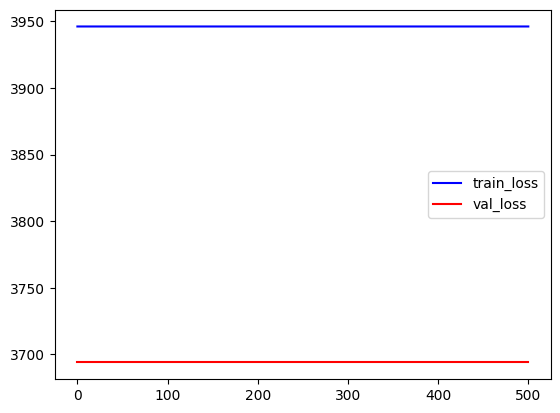

In [59]:
# to cpu
train_losses_cpu = train_losses
val_losses_cpu = val_losses

plt.plot(range(len(train_losses_cpu)),train_losses_cpu,color='blue',label='train_loss')
plt.plot(range(len(train_losses_cpu)),val_losses_cpu,color='red',label='val_loss')
plt.legend()
plt.show()

In [67]:
# test_TG 예측
feature_te_TG_tensors = Variable(torch.Tensor(feature_te_TG.values)).unsqueeze(1).to(device)

pred_test_TG = model(feature_te_TG_tensors).detach()

pred_test_TG = pred_test_TG.to('cpu')

In [68]:
pd.DataFrame(pred_test_TG)

,0
0,0.111297
1,0.111297
2,0.111297
3,0.111297
4,0.111297
...,...
275,0.111297
276,0.111297
277,0.111297
278,0.111297


아래부터는 feature_rest, target_rest로 학습 및 예측

In [24]:
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import lightgbm as lgb

def get_MSE(feature,target):
    # MSE를 스코어링 함수로 정의
    mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

    # LightGBM 모델 초기화
    model = lgb.LGBMRegressor(verbose = -1,force_col_wise = True)
    # force_col_wise = 메모리 이슈로 도중에 row-wise 탐색으로 바뀌는 것을 방지

    # 교차 검증 수행
    cross_val_scores = -cross_val_score(model, feature, target, cv=5, scoring=mse_scorer)
    rmse = np.sqrt(cross_val_scores)

    # 교차 검증 스코어 출력
    print("MAE scores for each fold:", rmse)  # Negative values are used because cross_val_score returns negated scores
    print("Mean MAE:", rmse.mean())

In [25]:
get_MSE(feature_rest,target_rest)

MAE scores for each fold: [ 463.0224741   370.18996645  343.47780897 1053.67303197  942.78706218]
Mean MAE: 634.6300687330363


In [26]:
def lbgm_feature_importance(feature,target):
    # LightGBM 모델 초기화
    model = lgb.LGBMRegressor(verbose = 0,force_col_wise=True)

    # 모델을 학습 , 중요도 계산
    model.fit(feature, target)

    # 피쳐 중요도 가져오기
    feature_importance = model.feature_importances_

    # 중요도가 높은 상위 20개 피쳐 인덱스 가져오기
    top_20_feature_indices = feature_importance.argsort()[-25:][::-1]

    # 상위 20개 피쳐의 중요도 가져오기
    top_20_feature_importance = feature_importance[top_20_feature_indices]

    # 상위 20개 피쳐의 이름 가져오기
    top_20_feature_names = feature.columns[top_20_feature_indices]

    # 중요도 시각화
    plt.figure(figsize=(10, 6))
    plt.barh(top_20_feature_names, top_20_feature_importance)
    plt.xlabel('Feature Importance')
    plt.title('Top 20 Feature Importance')
    plt.show()
    
    return top_20_feature_importance,top_20_feature_names

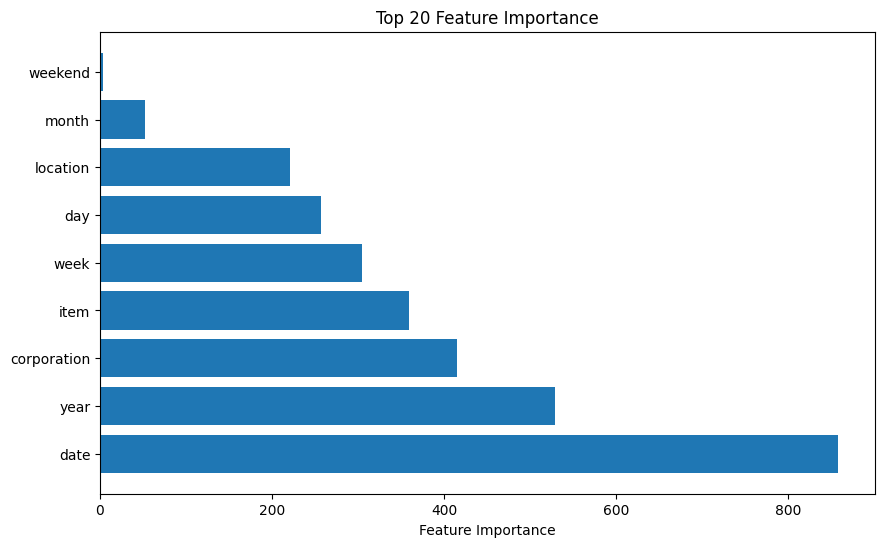

In [27]:
top_20_feature_importance,top_20_feature_names = lbgm_feature_importance(feature_rest,target_rest)

In [28]:
top_20_feature_importance, top_20_feature_names

(array([858, 529, 415, 359, 305, 257, 221,  52,   4]),
 Index(['date', 'year', 'corporation', 'item', 'week', 'day', 'location',
        'month', 'weekend'],
       dtype='object'))

In [29]:
# 피처 선택
# 2가지 버전 준비 
# 1. 피처 선택 버전
threshold = 150
low_importance_features_name = list(top_20_feature_names[np.where(top_20_feature_importance<150)[0]])
feature_rest_selected = feature_rest.drop(columns=low_importance_features_name)
feature_te_rest_selected = feature_te_rest.drop(columns=low_importance_features_name)
# 2. 모든 피처로 학습 >> feature, feature_te 그대로 사용

In [30]:
# 1. 피처 선택 버전 
# MSE 확인
get_MSE(feature_rest_selected,target_rest)
# 모델 학습 (아직 튜닝 미완료)
v1_lgbm_model = lgb.LGBMRegressor(force_col_wise=True)
v1_lgbm_model.fit(feature_rest_selected,target_rest)
v1_pred = v1_lgbm_model.predict(feature_te_rest_selected)

MAE scores for each fold: [ 451.34364393  370.55940005  348.68843382 1050.39407015  937.47196615]
Mean MAE: 631.6915028198136


In [31]:
# 2. 피처 선택 버전 
# MSE 확인
get_MSE(feature_rest,target_rest)
# 모델 학습 (아직 튜닝 미완료)
v2_lgbm_model = lgb.LGBMRegressor(force_col_wise=True)
v2_lgbm_model.fit(feature_rest,target_rest)
v2_pred = v2_lgbm_model.predict(feature_rest)

MAE scores for each fold: [ 463.0224741   370.18996645  343.47780897 1053.67303197  942.78706218]
Mean MAE: 634.6300687330363


In [40]:
### LSTM 예측값과 LGBM 예측값을 합쳐야 한다.
# LGBM 예측값
v1_pred_ = np.where(v1_pred<0,0,v1_pred) # 혹시 모를 음수값 대비
# index 정보 추가
v1_pred_ = pd.DataFrame(data=v1_pred_,index=org_test_rest_index,columns=['answer'])

# LSTM 예측값


,answer
280,1126.855933
281,87.655600
282,1965.646652
283,1849.066870
284,1849.066870
...,...
1087,506.793664
1088,502.757791
1089,502.757791
1090,502.757791


In [39]:
# sample_submission으로 저장하기
sample_submission = pd.read_csv('../data/sample_submission.csv')


sample_submission.head()

,ID,answer
0,TG_A_J_20230304,0
1,TG_A_J_20230305,0
2,TG_A_J_20230306,0
3,TG_A_J_20230307,0
4,TG_A_J_20230308,0


In [23]:
# save sample_submission
sample_submission.set_index('ID',inplace=True)
sample_submission.to_csv('../data/sample_20231103_1307.csv')